In [163]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch 
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt

In [164]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Multi-task Cascaded Convolutional Networks (MTCNN) For Face Detection

In [165]:
mtcnn = MTCNN(device = device)

**Load Pretrained InceptionResnet on vggface2 Dataset**

In [166]:
resnet = InceptionResnetV1(pretrained="vggface2", device = device).eval()

Create image array

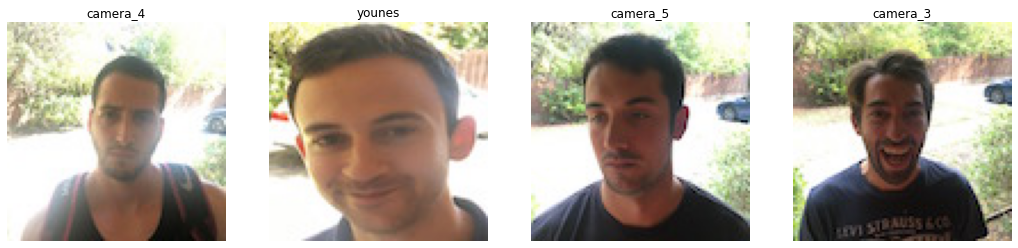

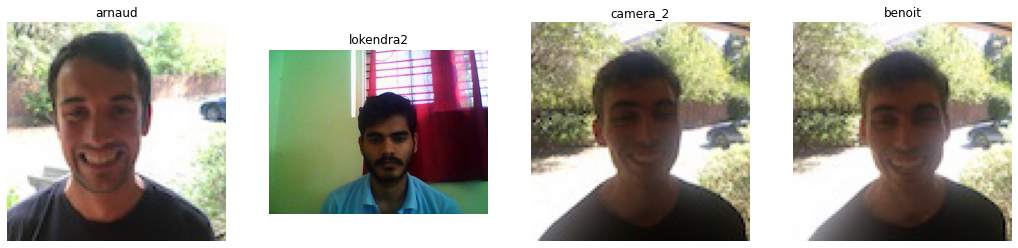

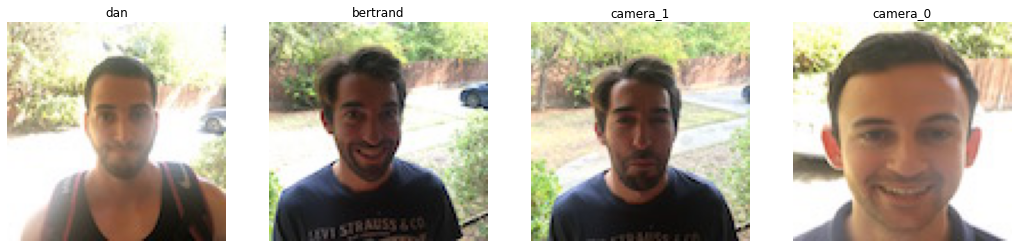

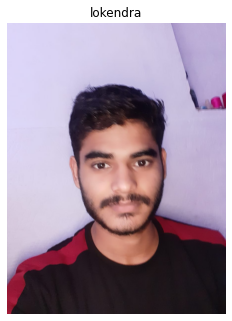

In [184]:
images = []
image_dir = os.listdir("./images")

for image in image_dir:
    image_name = image.split(".")[0]
    image_path = os.path.join("./images", image)
    images.append((image_path, image_name))

images = np.array(images)

for i in range(math.ceil(len(images)/4)):
    plt.figure(i, figsize=(18, 8))
    
    for j in range(4):
        if len(images) > (i*4 + j):
            plt.subplot(1, 4, j+1)
            plt.imshow(Image.open(images[i*4+j][0]).convert("RGB"))
            plt.title(images[i*4+j][1])
            plt.axis("off")

Extract face from image

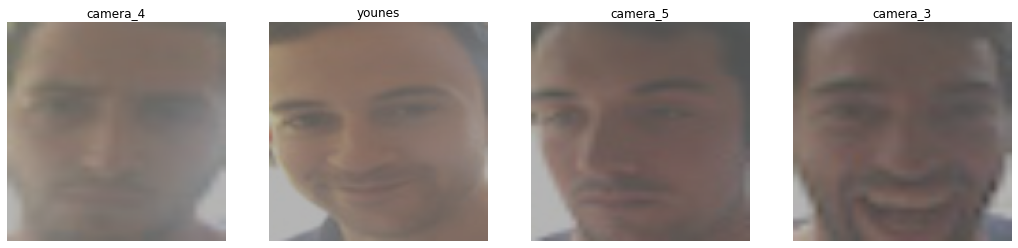

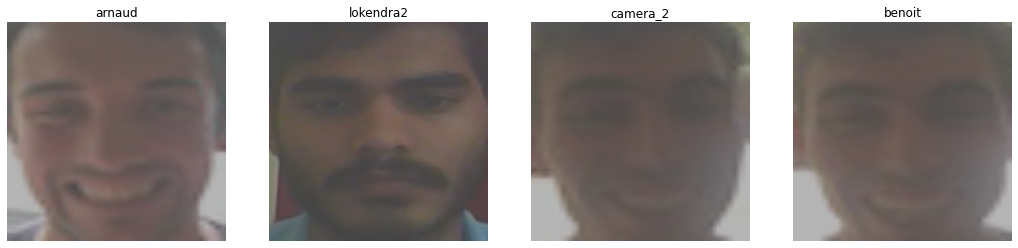

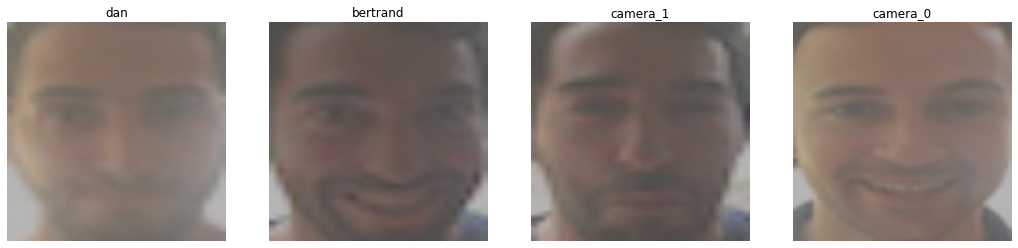

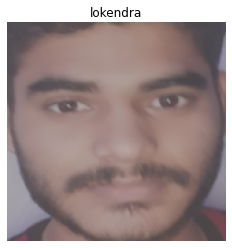

In [185]:
import math

cropped_images = []
labels = []
for i, (image, image_name) in enumerate(images):
    pil_image = Image.open(image).convert("RGB")
    image_croped, prob = mtcnn(pil_image, return_prob = True)
    
    cropped_images.append(image_croped)
    labels.append(image_name)

for i in range(math.ceil(len(cropped_images)/4)):
    plt.figure(i, figsize=(18, 8))
    
    for j in range(4):
        if len(images) > (i*4 + j):
            plt.subplot(1, 4, j+1)
            plt.imshow(cropped_images[i*4+j].permute(1, 2, 0)  * 0.229 + 0.485)
            plt.title(labels[i*4+j])
            plt.axis("off")


Face embeddings

In [186]:
embeddings = resnet(torch.stack(cropped_images))
embeddings.shape

torch.Size([13, 512])

In [190]:
embeddings_df = pd.DataFrame(embeddings.detach().numpy().T, columns = labels)
embeddings_df.head()

,camera_4,younes,camera_5,camera_3,arnaud,lokendra2,camera_2,benoit,dan,bertrand,camera_1,camera_0,lokendra
0,0.004404,-0.090640,0.006997,-0.059923,-0.002437,0.006513,-0.041745,-0.056494,0.007303,-0.064303,-0.037624,-0.042598,0.017802
1,0.021639,0.060490,-0.042806,-0.045492,-0.031896,-0.012295,0.048345,0.025690,0.022502,-0.085627,-0.023004,0.087805,-0.003516
2,0.019458,-0.048433,0.027196,0.003653,0.019676,0.001944,0.047918,-0.004916,0.015207,0.020943,-0.002532,-0.034844,-0.016702
3,0.009461,-0.061797,-0.029981,-0.078023,-0.040391,0.071479,0.080736,0.042613,0.005488,-0.047441,-0.031320,-0.081876,0.076959
4,-0.023655,0.043875,-0.015585,0.028506,0.024576,-0.019356,0.096111,0.096092,0.000515,0.045945,0.024674,0.043876,0.004106


**Correlation between diffrent face embeddings**

In [201]:
embeddings_corr = embeddings_df.corr().drop(columns = ["camera_4", "camera_5", "camera_2", 
                                                       "camera_3", "camera_1", "camera_0", "lokendra2"])

embeddings_corr.sort_values("lokendra").style.background_gradient(cmap='Blues')

,younes,arnaud,benoit,dan,bertrand,lokendra
younes,1.000000,0.368587,0.194452,0.330579,0.177061,-0.247438
camera_0,0.863361,0.381631,0.304066,0.265944,0.232950,-0.171371
arnaud,0.368587,1.000000,0.251745,0.360873,0.439395,-0.162550
bertrand,0.177061,0.439395,0.374511,0.012498,1.000000,-0.125410
camera_5,0.340318,0.596687,0.118977,0.349838,0.244552,-0.087643
camera_1,0.242743,0.323510,0.173613,0.264645,0.716773,-0.002672
camera_4,0.294671,0.171354,0.013755,0.709166,-0.141141,0.001754
camera_3,0.313493,0.479927,0.375330,0.274683,0.761131,0.028755
benoit,0.194452,0.251745,1.000000,0.073693,0.374511,0.035812
camera_2,0.147928,0.143468,0.881338,0.135127,0.268732,0.085398


### Our result)
1. lokendra  =~  lokendra2
2. camera_4  =~  dan
3. camera_5  =~  arnaud
4. camera_3  =~  bertrand
5. camera_2  =~  benoit
6. camera_1  =~  bertrand
7. camera_0  =~  younes

In [197]:
embeddings_df.corr()["lokendra"].sort_values()

younes      -0.247438
camera_0    -0.171371
arnaud      -0.162550
bertrand    -0.125410
camera_5    -0.087643
camera_1    -0.002672
camera_4     0.001754
camera_3     0.028755
benoit       0.035812
camera_2     0.085398
dan          0.163643
lokendra2    0.820822
lokendra     1.000000
Name: lokendra, dtype: float64

### lokendra embedding is max correlated to lokendra2 image